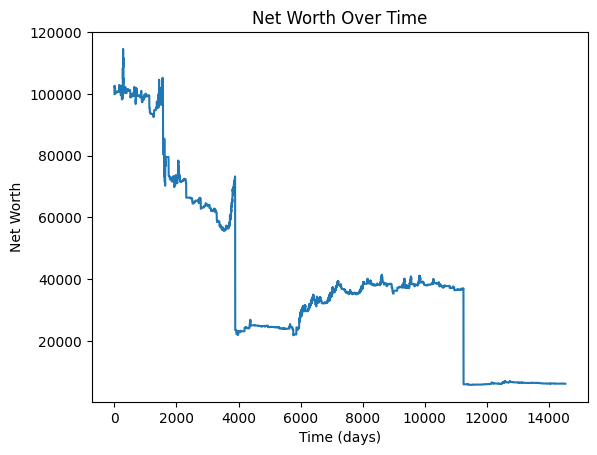

In [3]:
#Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#####Green= Module, Yellow= Function##### 
class QLearningAgent:
    def __init__(self, alpha, gamma, num_states, num_actions, eps):
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.eps = eps
        self.Q = np.zeros((num_states, num_actions))

    def get_action(self, state):
        if np.random.random() < self.eps:
            # take a random action
            return np.random.randint(0, self.num_actions)
        else:
            # take the best action based on current Q values
            return np.argmax(self.Q[state, :])

    def learn(self, state, action, reward, next_state):
        # update Q values
        q_next = np.max(self.Q[next_state, :])
        self.Q[state, action] += self.alpha * (reward + self.gamma * q_next - self.Q[state, action])


def load_data(filename):
    df = pd.read_csv(filename)
    return df['Close'].values


def get_state(prices, t):
    window_size = 5
    start_ix = t - window_size + 1
    end_ix = t + 1
    if start_ix < 0:
        start_ix = 0
    window = prices[start_ix:end_ix]
    min_price = np.min(window)
    max_price = np.max(window)
    current_price = prices[t]
    state = [
        min_price,
        max_price,
        current_price
    ]
    return np.array(state)


def run_simulation(agent, prices):
    starting_money = 100000
    initial_state = get_state(prices, 0)
    state = initial_state
    num_states = len(prices) - 1
    history = []
    cash = starting_money
    shares = 0
    for t in range(num_states):
        action = agent.get_action(np.argmax(state))
        if action == 0 and shares == 0:
            # buy shares
            shares = cash / prices[t]
            cash = 0
        elif action == 1 and cash == 0:
            # sell shares
            cash = shares * prices[t]
            shares = 0
        next_state = get_state(prices, t + 1)
        reward = 0
        if shares > 0:
            reward = next_state[2] - state[2]  # profit/loss
        agent.learn(np.argmax(state), action, reward, np.argmax(next_state))
        state = next_state
        net_worth = cash + shares * prices[t]
        history.append(net_worth)
    return history


if __name__ == '__main__':
    prices = load_data('DATASET14k.csv')
    num_states = 3
    num_actions = 2
    alpha = 0.1
    gamma = 0.9
    eps = 0.1
    agent = QLearningAgent(alpha, gamma, num_states, num_actions, eps)
    net_worth_history = run_simulation(agent, prices)

    # plot the results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(net_worth_history)
    ax.set_title('Net Worth Over Time')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Net Worth')
    plt.show()


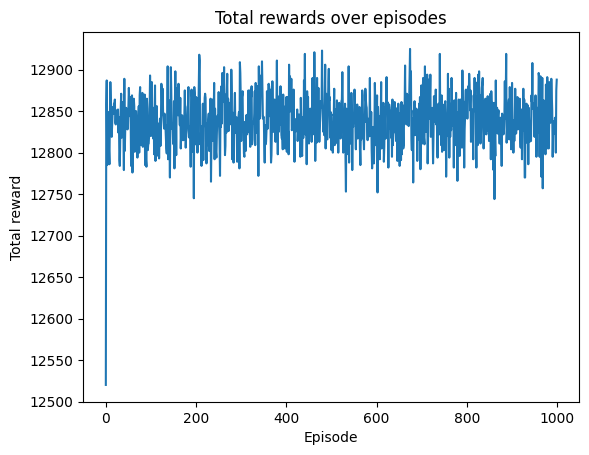

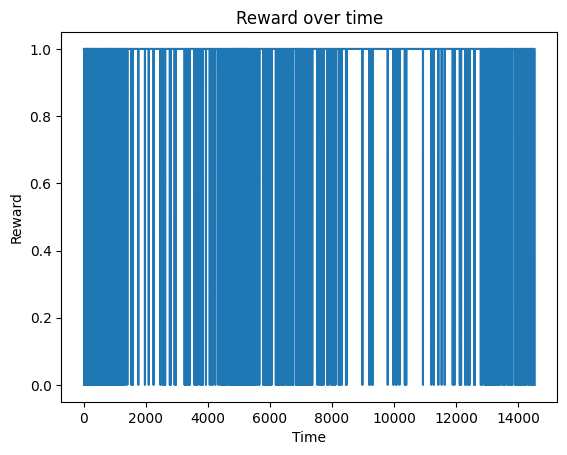

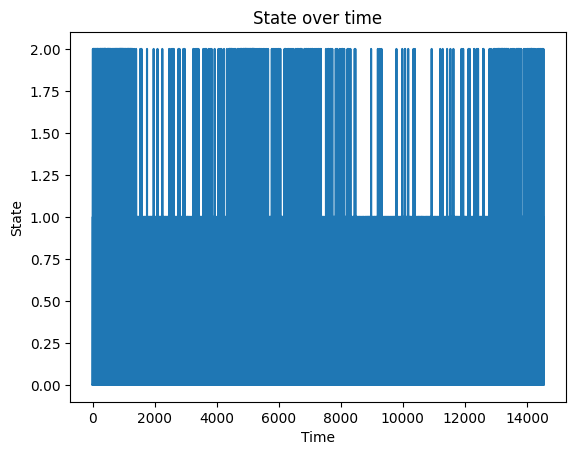

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the dataset
data = pd.read_csv('DATASET14k.csv')
data = data.dropna()

# Define the state space, action space and Q matrix
n_states = 5
n_actions = 3
Q = np.zeros((n_states, n_actions))

# Define the state function
def get_state(data, t):
    if data['Close'][t] < data['Open'][t]:
        return 0  # State 0: The price decreased
    elif data['Close'][t] > data['Open'][t]:
        return 1  # State 1: The price increased
    else:
        return 2  # State 2: The price remained the same

# Define the reward function
def get_reward(state, action):
    if state == 0 and action == 2:
        return 1  # Buy low, sell high: reward is 1
    elif state == 1 and action == 1:
        return 1  # Buy high, sell low: reward is 1
    else:
        return 0  # All other actions have no immediate reward

# Define the action function
def get_action(state, Q, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice([0, 1, 2])  # Choose a random action
    else:
        return np.argmax(Q[state])  # Choose the best action

# Define the learning function
def learn(state, action, reward, next_state, alpha, gamma):
    Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

# Define the Q-learning function
def q_learning(data, Q, alpha, gamma, epsilon, n_episodes):
    rewards = []
    for episode in range(n_episodes):
        state = get_state(data, 0)
        total_reward = 0
        for t in range(1, len(data)):
            action = get_action(state, Q, epsilon)
            reward = get_reward(state, action)
            next_state = get_state(data, t)
            learn(state, action, reward, next_state, alpha, gamma)
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return Q, rewards

# Set the learning parameters and start learning
alpha = 0.1
gamma = 0.9
epsilon = 0.1
n_episodes = 1000
Q, rewards = q_learning(data, Q, alpha, gamma, epsilon, n_episodes)

# Plot the rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Total rewards over episodes')
plt.show()

# Make predictions for the test data
test_data = pd.read_csv('DATASET14k.csv')
test_data = test_data.dropna()
test_rewards = []
states = []
state = get_state(data, 0)
for t in range(len(test_data)):
    action = np.argmax(Q[state])
    reward = get_reward(state, action)
    state = get_state(test_data, t)
    test_rewards.append(reward)
    states.append(state)

# Plot the test rewards and states
plt.plot(test_rewards)
plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Reward over time')
plt.show()

plt.plot(states)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('State over time')
plt.show()
